<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports and Scripts

In [3]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [4]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')



In [62]:
# imports and constants
import json
import pickle
import datetime as dt

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

from IPython.display import display, HTML
import ipywidgets as widgets

# user imports
from utils.process_data import *
from utils.stats import *
from utils.lifesense_utils import *

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [7]:
baseline_redcap_df = pd.read_excel("data_pull/LS_Wave1_SC_BL_WK1_Data_081419-revised.xlsx",
                            sheet_name=0)

mapping_df = pd.read_csv("data_pull/Wave1LifeSenseEnroll_DATA_LABELS_2019-08-15_0929.csv")

baseline_redcap_dict = dict(zip(mapping_df['Case#:'], mapping_df['LifeSense Study App ID:    ']))

baseline_redcap_df['pid'] = baseline_redcap_df['study_id'].map(baseline_redcap_dict)

def pad_pid(row):
    if len(row['pid']) < 8:
        return ('0' * (8-len(row['pid']))) + row['pid']
    else:
        return row['pid']

baseline_redcap_df['pid'] = baseline_redcap_df['pid'].astype(str)
baseline_redcap_df['pid'] = baseline_redcap_df.apply(pad_pid, axis=1)

age_dict = dict(zip(baseline_redcap_df['pid'], baseline_redcap_df['age']))
# 1 is male, 0 is female
gender_dict = dict(zip(baseline_redcap_df['pid'], baseline_redcap_df['demo_gender']))

In [149]:
state_df = pd.read_pickle("ls_data/state_all.df")
phq_df = pd.read_pickle("ls_data/phq_0_16.df")
cluster_df = pd.read_pickle("ls_data/train_cluster.df").to_frame()
cluster_df = cluster_df.reset_index()

cluster_df['cluster'] = cluster_df['cluster'].map({
    0: 'no_symp',
    1: 'soc_anx',
    2: 'gen_anx',
    3: 'dep_anx'
})

# Survey Descriptives

In [11]:
cluster_dict = {k:v for k, v in zip(cluster_df['pid'].values, cluster_df['cluster'].values)}

phq_df = phq_df[phq_df['pid'].isin(cluster_df['pid'])]
phq_df['baseline_cluster'] = phq_df['pid'].map(cluster_dict)

In [12]:
event_dict = {
   "week_0_arm_1": 0,
   "week_1_arm_1": 1,
   "week_4_arm_1": 4,
   "week_7_arm_1": 7,
   "week_10_arm_1": 10,
   "week_13_arm_1": 13,
   "week_16_arm_1": 16
}

phq_df['study_wk'] = phq_df['redcap_event_name'].map(event_dict)


## PHQ 

### Investigating high baseline PHQs

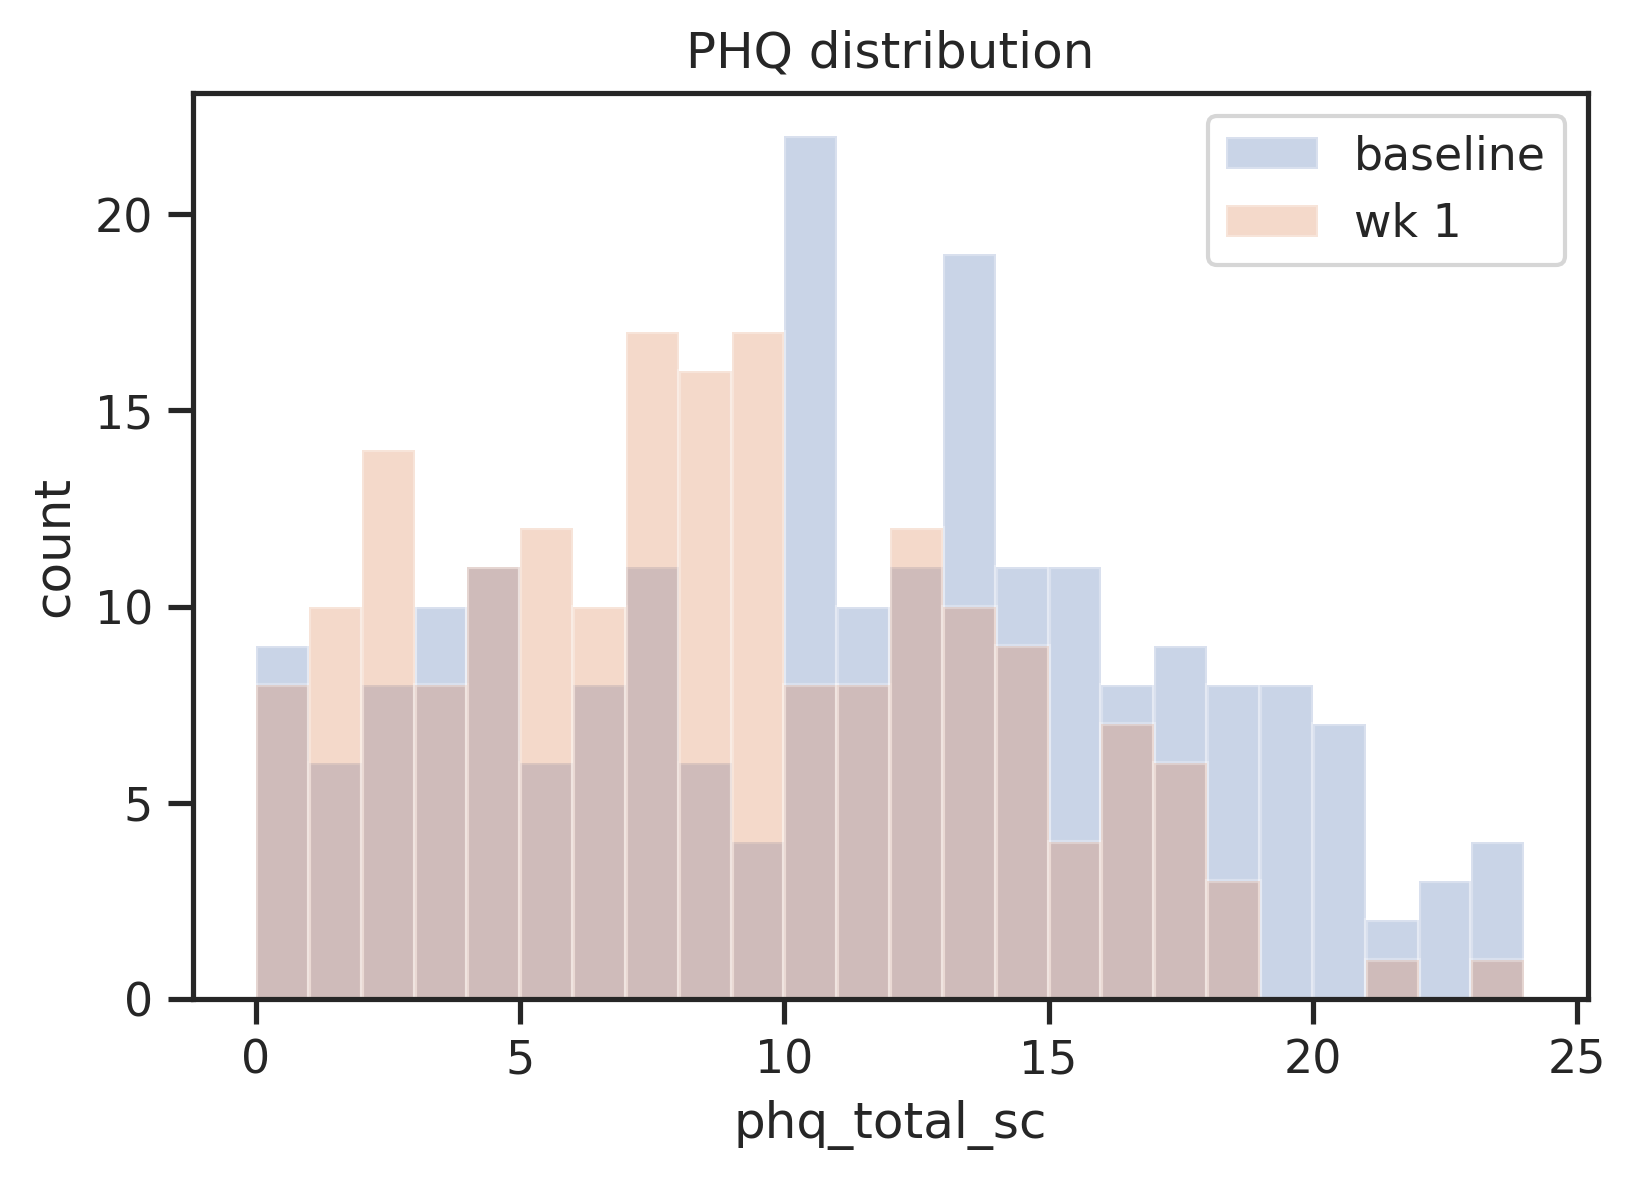

In [88]:
fig, ax = plt.subplots()
baseline_phq = phq_df[phq_df['redcap_event_name'] == 'week_0_arm_1']
sns.distplot(baseline_phq['phq_total_sc'], bins=24, label="baseline", kde=False, ax=ax, 
             hist_kws = {'alpha': 0.3})

wk1_phq = phq_df[phq_df['redcap_event_name'] == 'week_1_arm_1']
wk1_phq = wk1_phq.drop_duplicates(subset=['pid'], keep='first')
sns.distplot(wk1_phq['phq_total_sc'], bins=24,  label="wk 1", kde=False, ax=ax,
             hist_kws = {'alpha': 0.3})
plt.title("PHQ distribution")
plt.ylabel("count")
plt.legend()
plt.show()

In [89]:
# take the baseline average of the missing pids week by week
baseline_pids = baseline_phq['pid'].unique()

missing_df = pd.DataFrame()
for event in list(event_dict.keys())[1:]:
    wk_df = phq_df[phq_df['redcap_event_name'] == event]
    wk_df = wk_df.drop_duplicates(subset=['pid'])
    wk_pids = wk_df['pid'].unique()
    missing_pids = [x for x in baseline_pids if x not in wk_pids]
    #print(missing_pids)
    desc_df = pd.DataFrame({event[:-6] + "_missing": baseline_phq[baseline_phq['pid'].isin(missing_pids)]['phq_total_sc'].describe()})
    missing_df = pd.concat([missing_df, desc_df], axis=1)
    #display(missing_df)

In [90]:
baseline_descr = pd.DataFrame({'baseline_all' : baseline_phq['phq_total_sc'].describe()})

pd.concat([baseline_descr, missing_df], axis=1)

,baseline_all,week_1_missing,week_4_missing,week_7_missing,week_10_missing,week_13_missing,week_16_missing
count,212.000000,20.000000,55.000000,34.000000,27.000000,31.000000,36.000000
mean,10.768868,11.700000,11.363636,12.088235,12.814815,11.645161,12.138889
std,6.064298,5.831854,6.648207,6.770559,6.928409,7.007369,7.115989
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,8.250000,6.000000,9.250000,10.000000,7.000000,8.000000
50%,11.000000,11.500000,11.000000,12.000000,13.000000,12.000000,12.500000
75%,15.000000,16.000000,17.000000,17.750000,18.000000,16.500000,17.250000
max,24.000000,24.000000,23.000000,24.000000,24.000000,24.000000,24.000000


# SPIN

In [212]:
state_df = pd.read_pickle("ls_data/state_all.df")
cluster_dict = {k:v for k, v in zip(cluster_df['pid'].values, cluster_df['cluster'].values)}

state_df = state_df[state_df['pid'].isin(cluster_df['pid'])]
state_df['baseline_cluster'] = state_df['pid'].map(cluster_dict)

In [213]:
spin_cols = state_df.columns[state_df.columns.str.contains('spin')][1:]
state_df[spin_cols].describe()

,spin_01,spin_02,spin_03,spin_04,spin_05,spin_06,spin_07,spin_08,spin_09,spin_10,spin_11,spin_12,spin_13,spin_14,spin_15,spin_16,spin_17
count,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000
mean,1.867450,1.988255,1.510906,1.565436,1.853188,2.462248,1.159396,3.362416,2.758389,1.194631,2.714765,1.585570,0.733221,1.495805,1.587248,0.921980,1.059564
std,28.927528,28.930413,1.320210,1.279856,1.366908,28.918170,1.304811,40.859299,28.917271,1.224863,28.921838,1.353936,1.121189,1.318976,1.388125,1.150966,1.292220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000,1.000000,2.000000,3.000000,2.000000,2.000000
max,999.000000,999.000000,4.000000,4.000000,4.000000,999.000000,4.000000,999.000000,999.000000,4.000000,999.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [214]:
# impute 999s with median, only a few
display(state_df[state_df[spin_cols] > 4][spin_cols].describe())
state_df = state_df.replace(to_replace=999, value=1)

,spin_01,spin_02,spin_03,spin_04,spin_05,spin_06,spin_07,spin_08,spin_09,spin_10,spin_11,spin_12,spin_13,spin_14,spin_15,spin_16,spin_17
count,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,999.0,999.0,NaN,NaN,NaN,999.0,NaN,999.0,999.0,NaN,999.0,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,999.0,999.0,NaN,NaN,NaN,999.0,NaN,999.0,999.0,NaN,999.0,NaN,NaN,NaN,NaN,NaN,NaN
25%,999.0,999.0,NaN,NaN,NaN,999.0,NaN,999.0,999.0,NaN,999.0,NaN,NaN,NaN,NaN,NaN,NaN
50%,999.0,999.0,NaN,NaN,NaN,999.0,NaN,999.0,999.0,NaN,999.0,NaN,NaN,NaN,NaN,NaN,NaN
75%,999.0,999.0,NaN,NaN,NaN,999.0,NaN,999.0,999.0,NaN,999.0,NaN,NaN,NaN,NaN,NaN,NaN
max,999.0,999.0,NaN,NaN,NaN,999.0,NaN,999.0,999.0,NaN,999.0,NaN,NaN,NaN,NaN,NaN,NaN


In [215]:
state_df['spin_total'] = state_df[spin_cols].sum(axis=1, skipna=False)
state_df['study_wk'] = state_df['redcap_event_name'].map(event_dict)

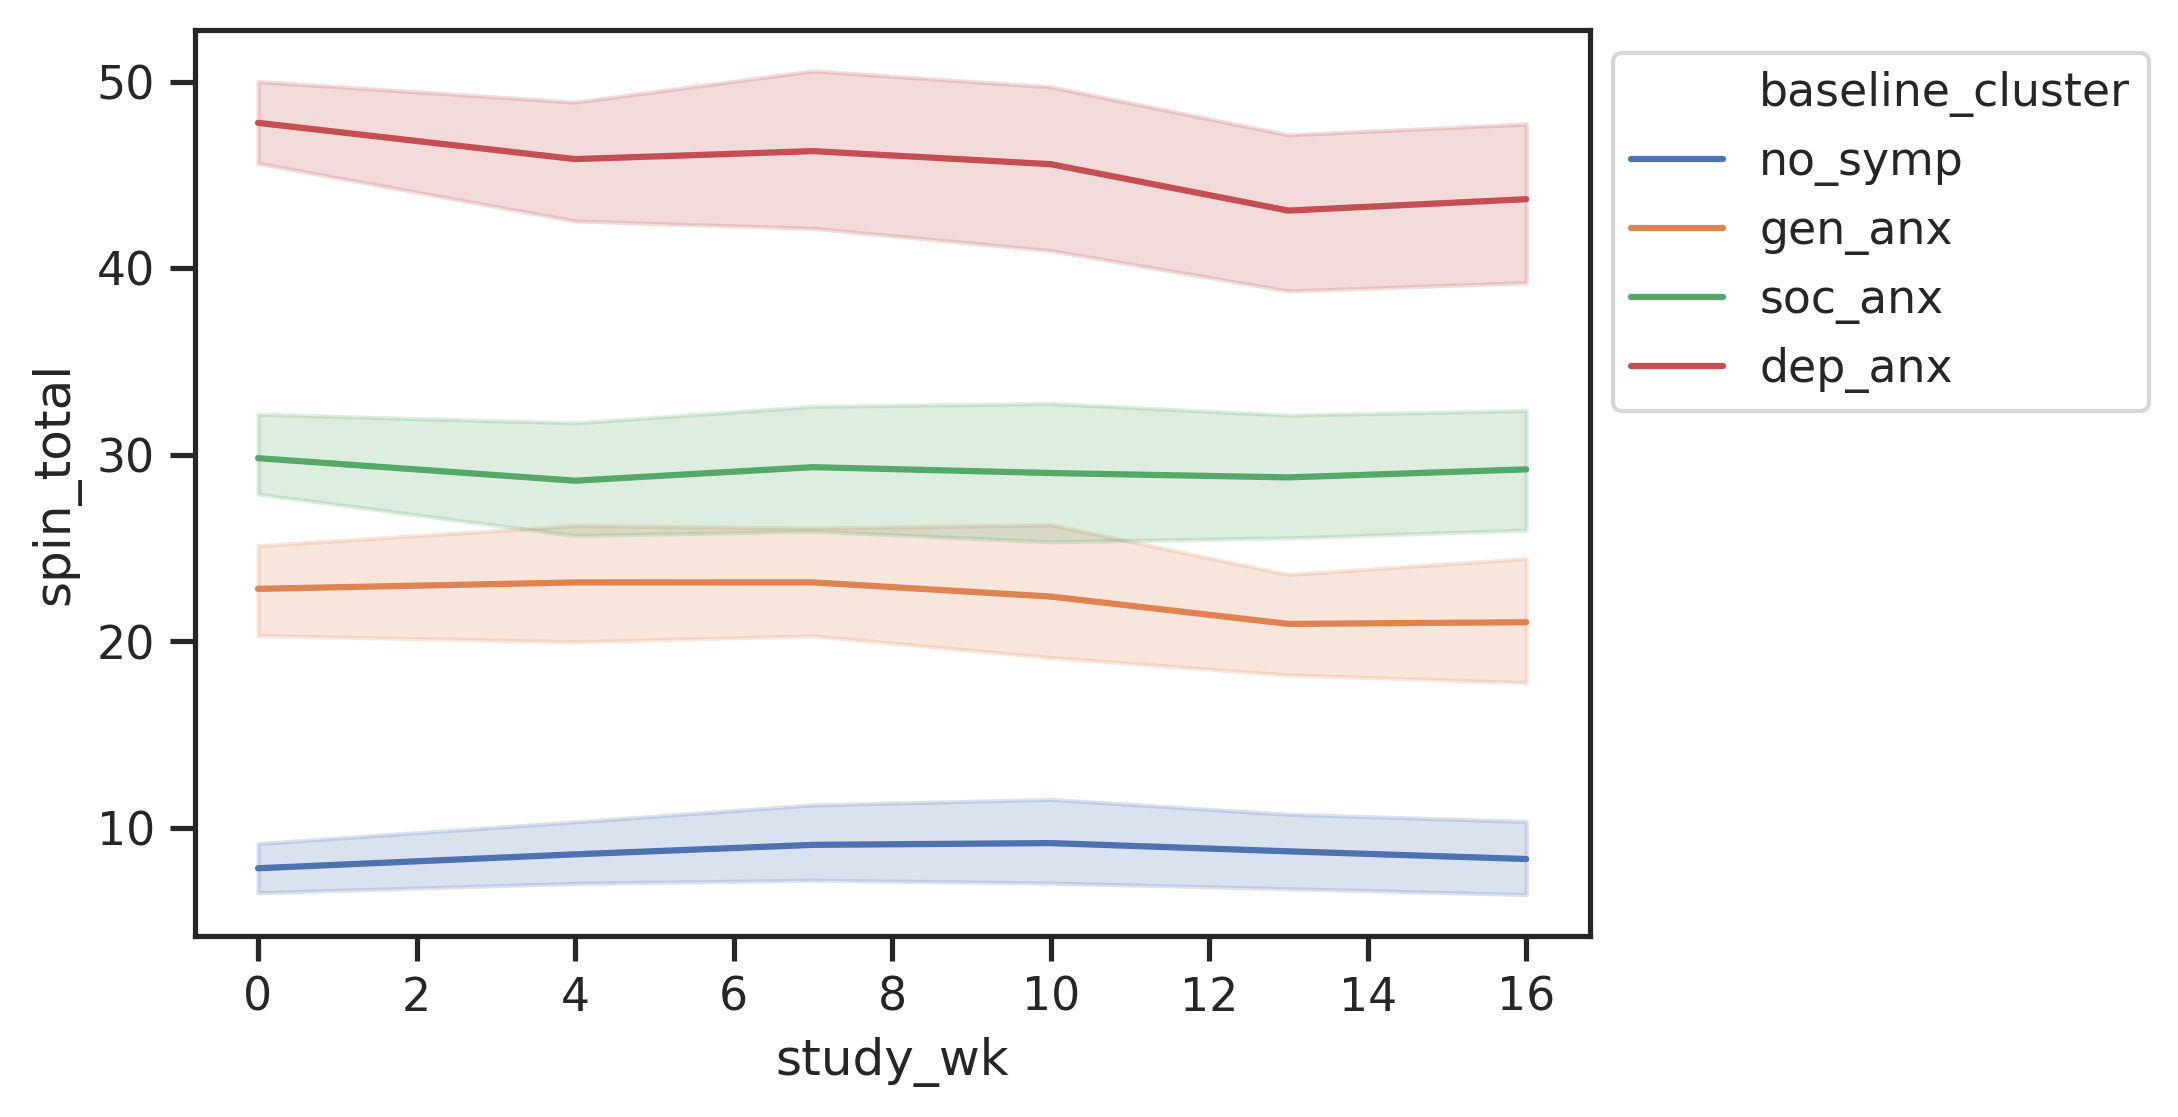

In [216]:
state_df['spin_start'] = pd.to_datetime(state_df['spin_start'])
g = sns.lineplot(x="study_wk", y="spin_total", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=state_df)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

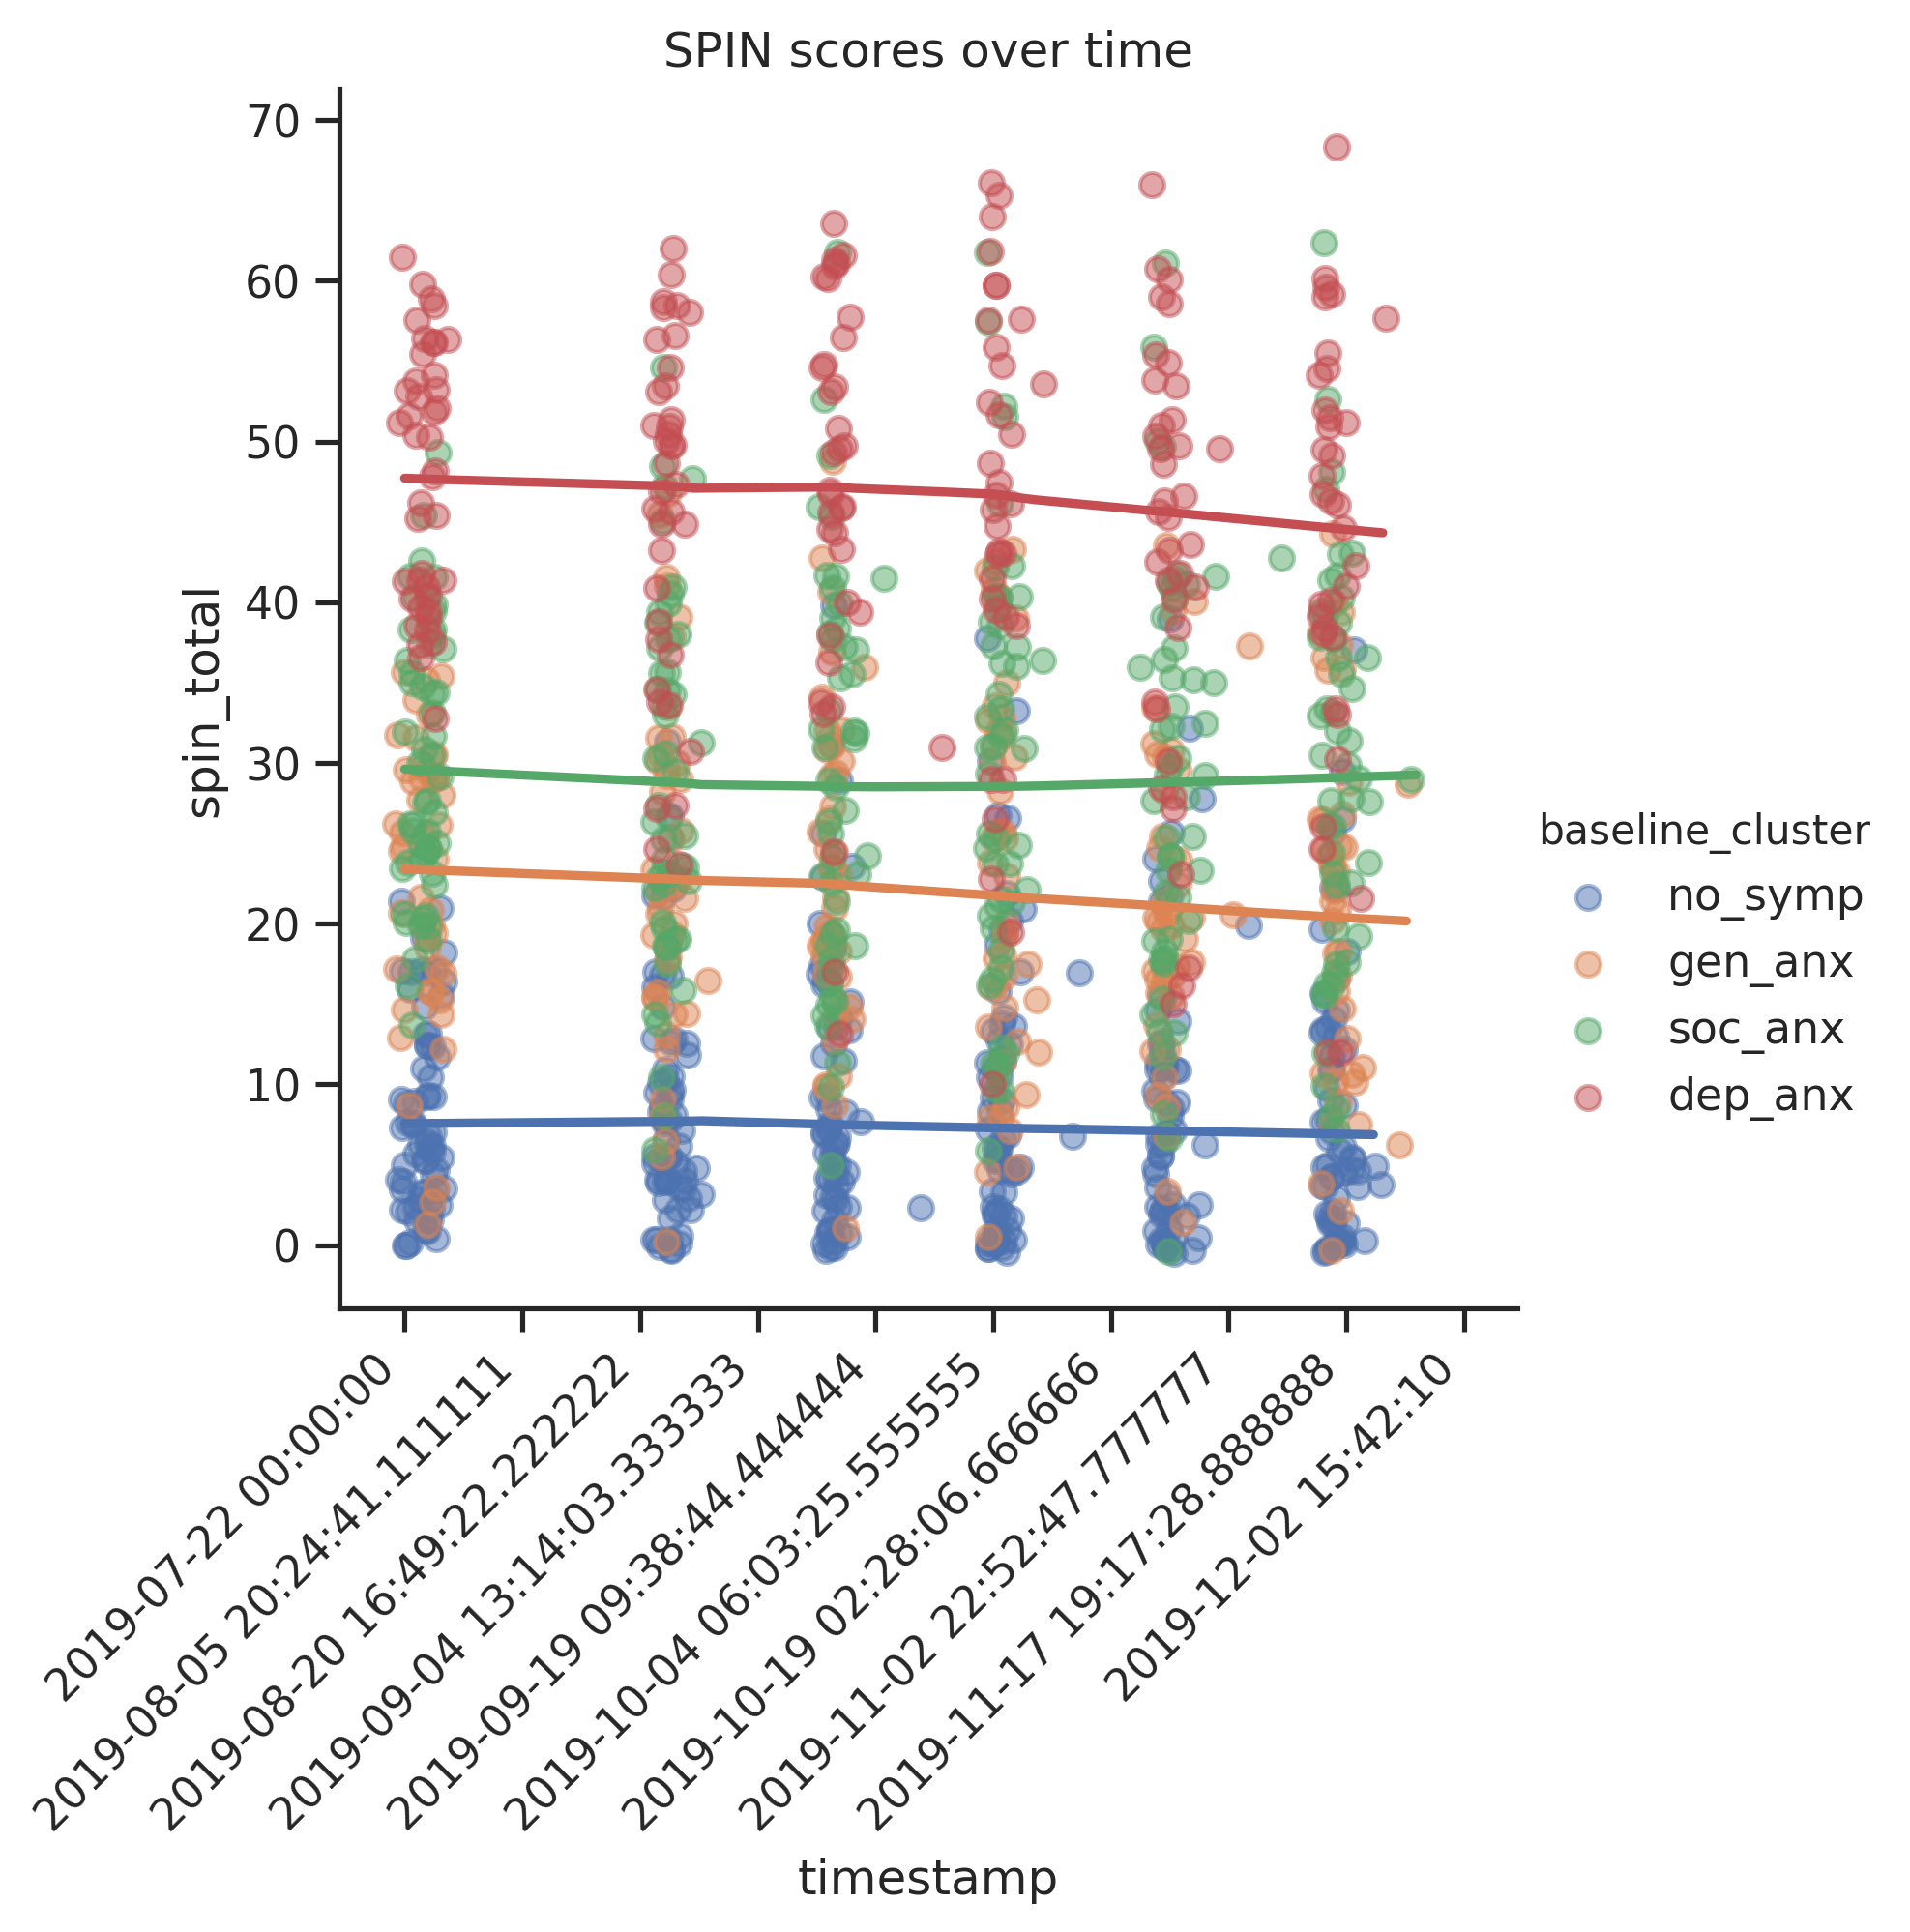

In [217]:
state_df['timestamp'] = (state_df['spin_start'] - dt.datetime(1970,1,1)).dt.total_seconds()
import matplotlib.dates as md


sns.lmplot(x='timestamp', y='spin_total', 
           data=state_df, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=100000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.5
           },
          )
ax=plt.gca()
ticks = np.linspace(state_df['timestamp'].min(), state_df['timestamp'].max(), 10)
idx = pd.date_range(state_df['spin_start'].min(), state_df['spin_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
plt.title("SPIN scores over time")
plt.show()

# GAD

In [218]:
gad_cols = state_df.columns[state_df.columns.str.contains('gad')][1:]
gad_cols = gad_cols.drop('gad08')
state_df[gad_cols].describe()

state_df = state_df[state_df['pid'].isin(cluster_df['pid'])]
state_df['baseline_cluster'] = state_df['pid'].map(cluster_dict)

In [219]:
# impute 99s with median, only a few
display(state_df[state_df[gad_cols] > 4][gad_cols].describe())
state_df = state_df.replace(to_replace=99, value=1)

,gad01,gad02,gad03,gad04,gad05,gad06,gad07
count,0.0,0.0,0.0,0.0,1.0,1.0,0.0
mean,NaN,NaN,NaN,NaN,99.0,99.0,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,99.0,99.0,NaN
25%,NaN,NaN,NaN,NaN,99.0,99.0,NaN
50%,NaN,NaN,NaN,NaN,99.0,99.0,NaN
75%,NaN,NaN,NaN,NaN,99.0,99.0,NaN
max,NaN,NaN,NaN,NaN,99.0,99.0,NaN


In [220]:
state_df['gad_total'] = state_df[gad_cols].sum(axis=1, skipna=False)
state_df['study_wk'] = state_df['redcap_event_name'].map(event_dict)

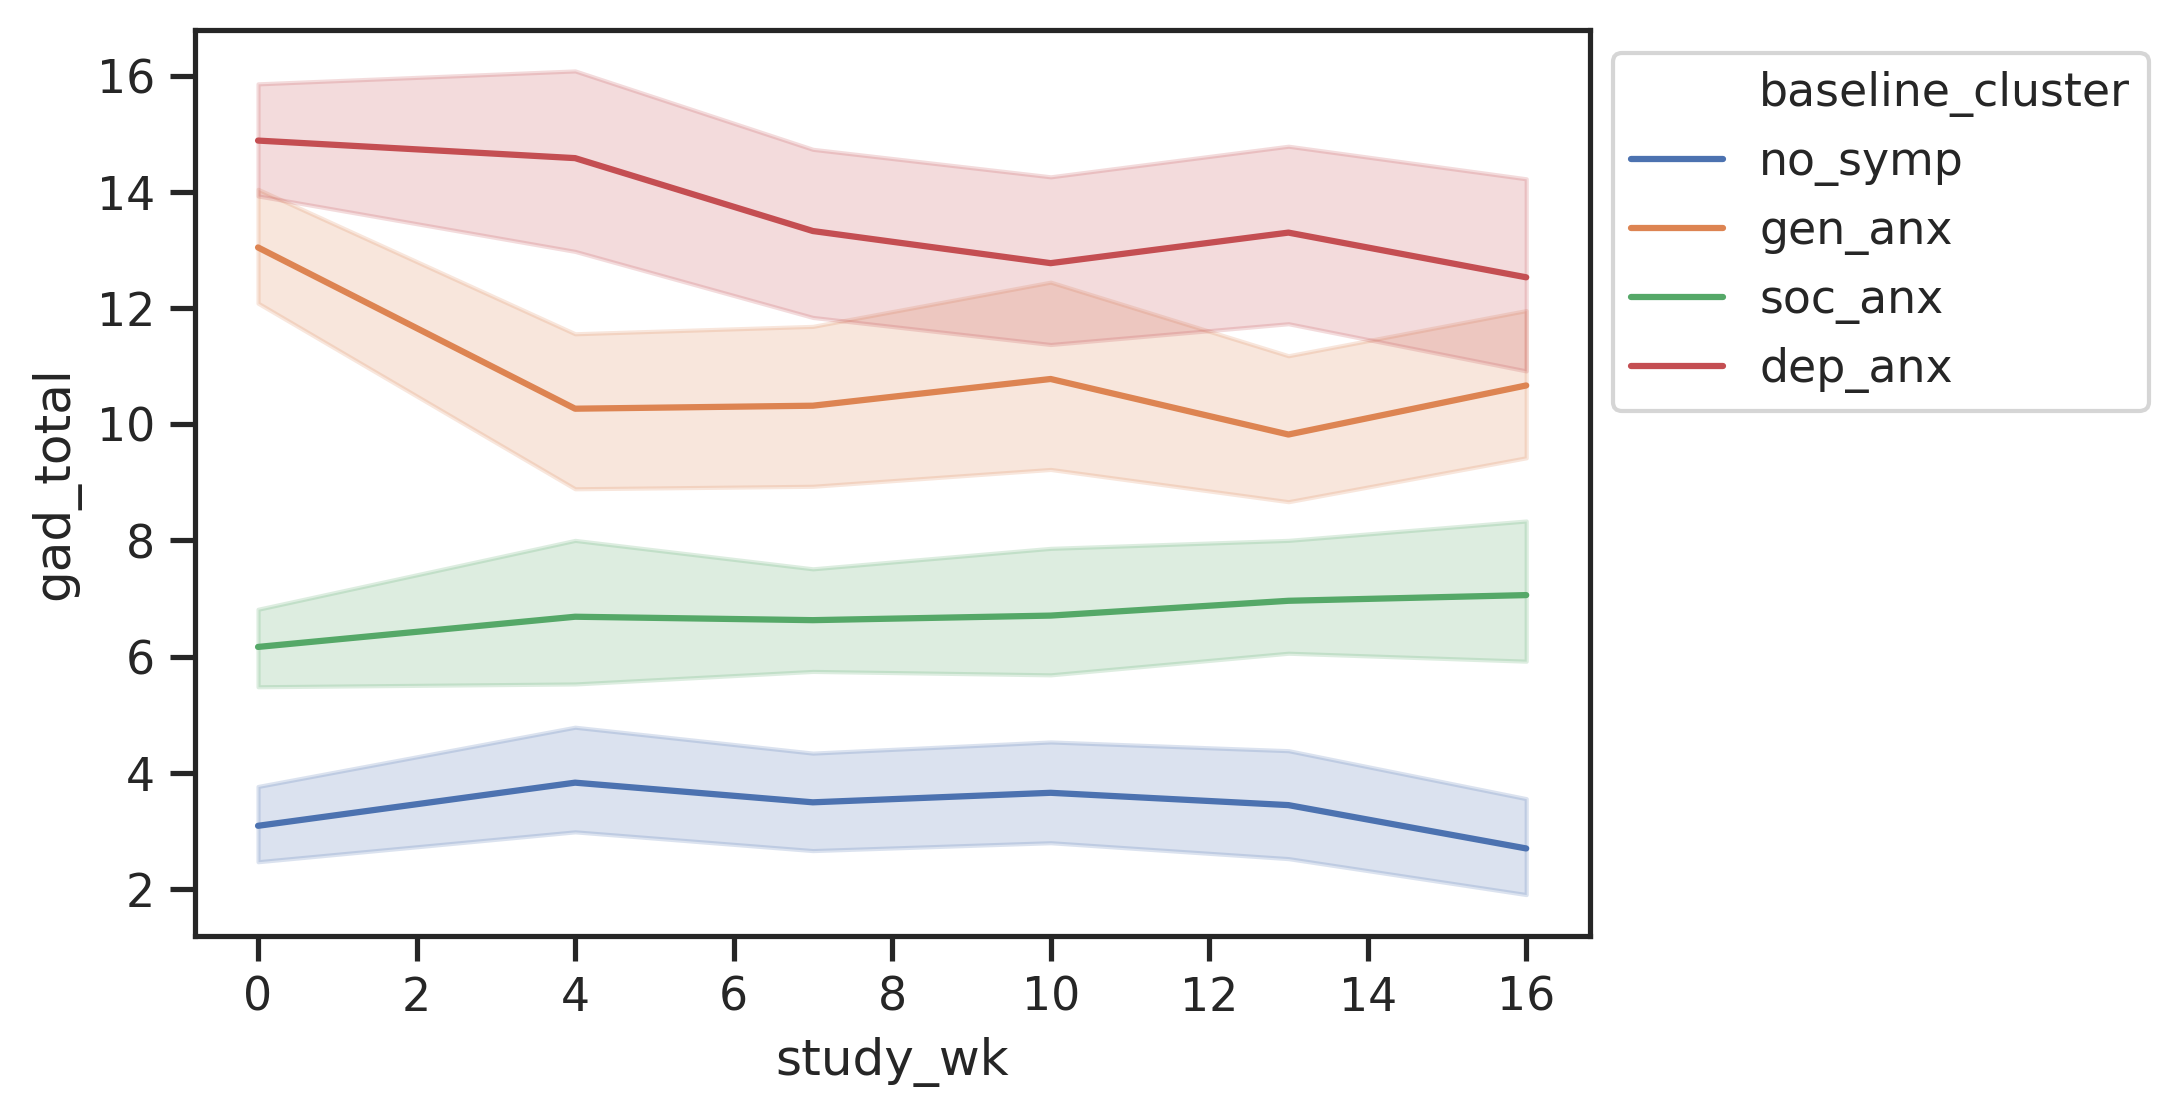

In [221]:
state_df['gad_start'] = pd.to_datetime(state_df['gad_start'])
g = sns.lineplot(x="study_wk", y="gad_total", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=state_df)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

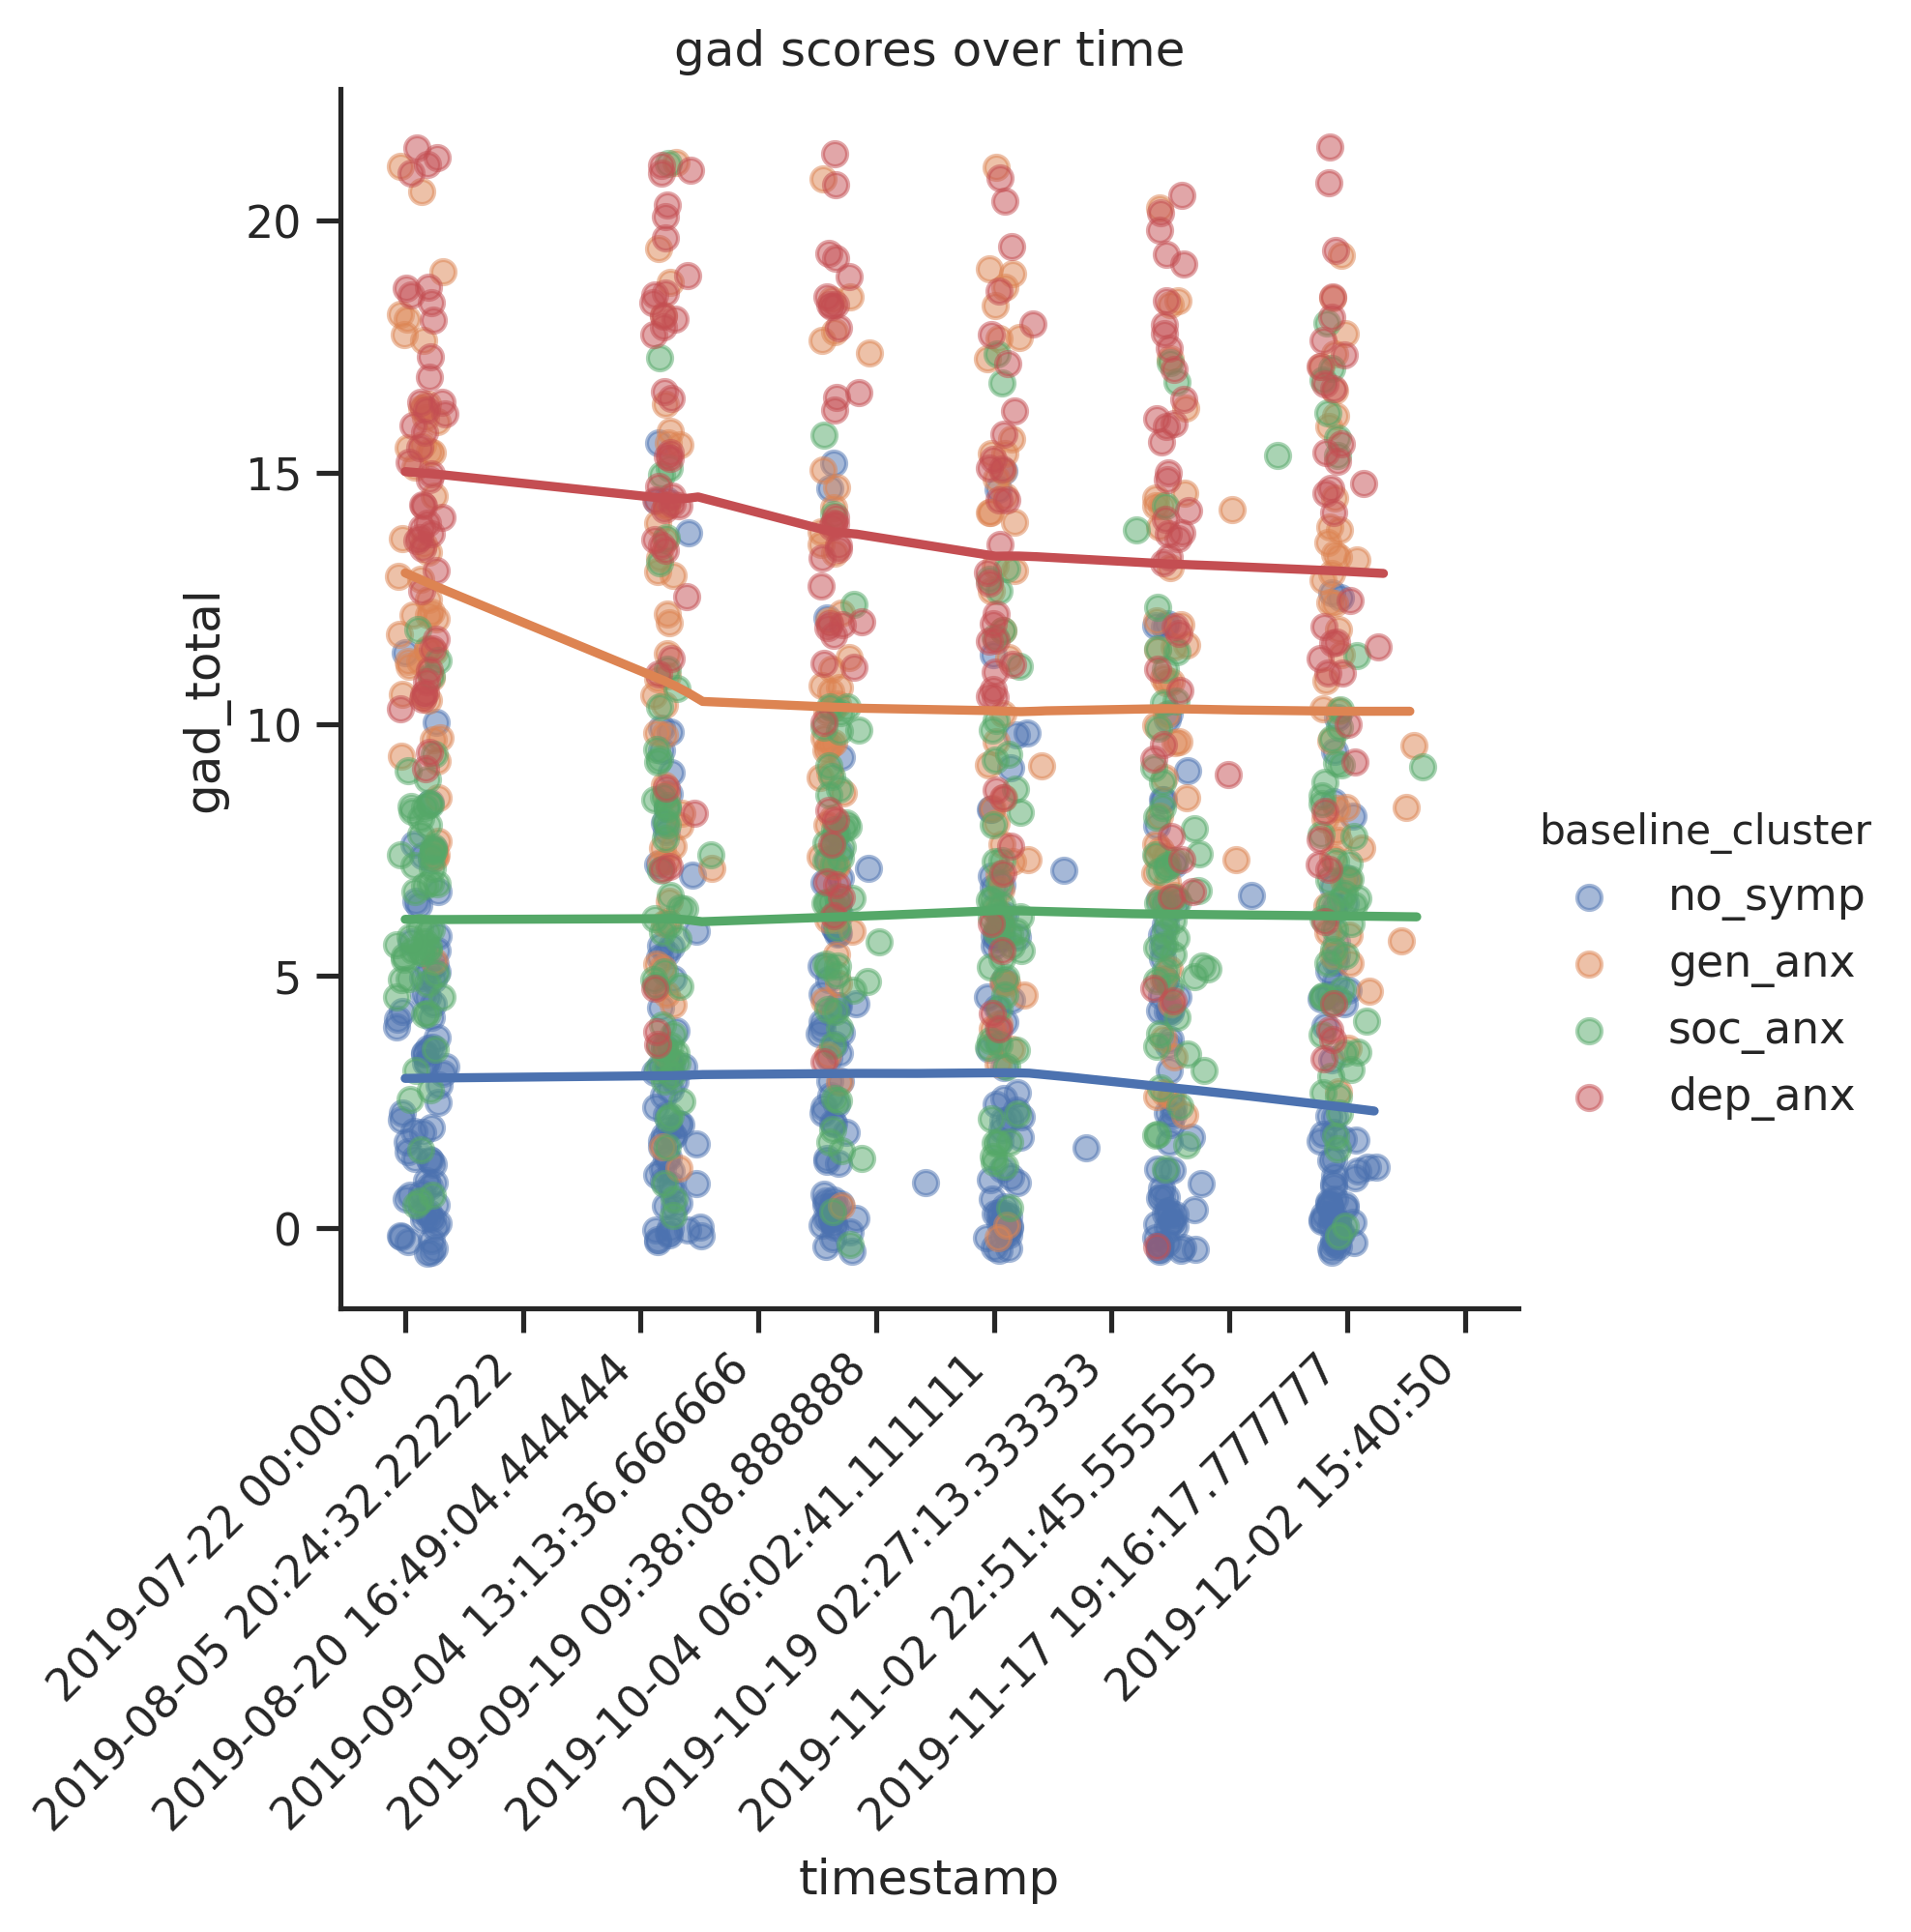

In [222]:
state_df['timestamp'] = (state_df['gad_start'] - dt.datetime(1970,1,1)).dt.total_seconds()
import matplotlib.dates as md


sns.lmplot(x='timestamp', y='gad_total', 
           data=state_df, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=100000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.5
           },
          )
ax=plt.gca()
ticks = np.linspace(state_df['timestamp'].min(), state_df['timestamp'].max(), 10)
idx = pd.date_range(state_df['gad_start'].min(), state_df['gad_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
plt.title("gad scores over time")
plt.show()

# Shift DataFrame Construction

In [235]:
def build_fill_shift_df(shift_df, target, wks = [1,4,7,10,13,16], impute_mean=False):
    """Constructs a full shifted DataFrame with missing survey idxs filled with mean or nans.
    
    Args:
        shift_df (pd.df): the shifted DataFrame
        target (str): the target survey column (eg phq_total_sc)
        impute_mean (bool): whether or not to fill missing surveys with the individual's mean PHQ score
    Returns:
        fill_shift_df (pd.df): the filled DataFrame, with all events represented for each individual
    """
    
    fill_shift_df = pd.DataFrame()

    for pid, group in shift_df.groupby('pid'):
        group = group.reset_index(drop=True)
        group_mean = group[target].mean()
        for idx, wk in enumerate(wks):
            cur_event = "week_{}_arm_1".format(wk)

            sel = group[group['redcap_event_name'] == cur_event]
            if sel.shape[0] > 0:
                sel_idx = sel.index[0]
                fill_shift_df = fill_shift_df.append(group.iloc[sel_idx, :])
            # else we have to fill an empty row in the DataFrame    
            else:
                empty = pd.DataFrame(index=[0], columns=group.columns)
                empty['redcap_event_name'] = cur_event
                
                if impute_mean:
                    fill_val = group_mean
                else:
                    fill_val = np.nan
                    
                empty[target] = fill_val
                empty['pid'] = pid
                fill_shift_df = fill_shift_df.append(empty)
                
    fill_shift_df['survey_idx'] = fill_shift_df.groupby('pid').cumcount()+1
    
    return fill_shift_df

## SPIN

In [224]:
spin_shift_df = state_df.copy()

In [225]:
# map cluster assignments
spin_shift_df['cluster'] = spin_shift_df['pid'].map(cluster_dict)
spin_shift_df = spin_shift_df.sort_values(by=['pid', 'spin_start'])

spin_shift_df = spin_shift_df[spin_shift_df['redcap_event_name'] != 'week_0_arm_1']
spin_shift_df['spin_start'] = pd.to_datetime(spin_shift_df['spin_start'])
spin_shift_df['spin_start_shift'] = spin_shift_df.groupby('pid')['spin_start'].shift(1)
spin_shift_df['diff'] = spin_shift_df['spin_start'] - spin_shift_df['spin_start_shift']

In [226]:
spin_shift_df[['pid', 'redcap_event_name', 'spin_start', 'spin_start_shift', 'diff']].head()

,pid,redcap_event_name,spin_start,spin_start_shift,diff
405,00746649,week_4_arm_1,2019-08-23 19:07:47,NaT,NaT
406,00746649,week_7_arm_1,2019-09-14 15:42:28,2019-08-23 19:07:47,21 days 20:34:41
407,00746649,week_10_arm_1,2019-10-04 16:28:17,2019-09-14 15:42:28,20 days 00:45:49
78,00746649,week_13_arm_1,2019-10-25 22:41:12,2019-10-04 16:28:17,21 days 06:12:55
79,00746649,week_16_arm_1,2019-11-15 10:41:55,2019-10-25 22:41:12,20 days 12:00:43


In [227]:
spin_shift_df[spin_shift_df['diff'] < pd.to_timedelta(14, unit='d')]

,pid,redcap_event_name,gad_start,gad01,gad02,gad03,gad04,gad05,gad06,gad07,...,spin_16,spin_17,baseline_cluster,spin_total,study_wk,timestamp,gad_total,cluster,spin_start_shift,diff
859,18740846,week_10_arm_1,2019-10-04 12:47:45,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,no_symp,0.0,10,1.570193e+09,4.0,no_symp,2019-10-04 12:39:34,0 days 00:12:18
111,19410615,week_16_arm_1,2019-11-16 23:08:20,3.0,3.0,3.0,3.0,1.0,3.0,3.0,...,3.0,0.0,gen_anx,40.0,16,1.573946e+09,19.0,gen_anx,2019-11-04 12:21:39,12 days 11:01:26
1107,24936642,week_10_arm_1,2019-10-04 18:12:04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,no_symp,1.0,10,1.570213e+09,0.0,no_symp,2019-09-24 14:32:37,10 days 03:46:22
355,45433155,week_16_arm_1,2019-11-17 05:35:18,2.0,1.0,0.0,2.0,0.0,0.0,0.0,...,1.0,0.0,no_symp,18.0,16,1.573969e+09,5.0,no_symp,2019-11-05 09:23:53,11 days 20:13:37
389,50931782,week_16_arm_1,2019-11-15 20:41:30,3.0,2.0,2.0,2.0,2.0,3.0,2.0,...,3.0,1.0,soc_anx,39.0,16,1.573850e+09,16.0,soc_anx,2019-11-08 20:50:22,6 days 23:54:24
518,59654069,week_13_arm_1,2019-10-25 10:31:11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,no_symp,11.0,13,1.571999e+09,2.0,no_symp,2019-10-14 01:50:16,11 days 08:42:56
2774,62463869,week_7_arm_1,2019-09-13 11:51:18,2.0,1.0,1.0,2.0,2.0,1.0,0.0,...,0.0,3.0,gen_anx,24.0,7,1.568375e+09,9.0,gen_anx,2019-09-13 11:45:31,0 days 00:11:42
2359,73326278,week_10_arm_1,2019-10-28 16:05:30,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1.0,2.0,dep_anx,38.0,10,1.572279e+09,14.0,dep_anx,2019-10-27 12:33:11,1 days 03:34:33
196,74575289,week_13_arm_1,2019-10-26 12:47:04,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,no_symp,6.0,13,1.572094e+09,5.0,no_symp,2019-10-15 09:11:34,11 days 03:40:41
2783,84877086,week_10_arm_1,2019-10-04 16:44:49,1.0,0.0,1.0,2.0,0.0,3.0,0.0,...,1.0,3.0,soc_anx,36.0,10,1.570207e+09,7.0,soc_anx,2019-10-04 16:37:34,5 days 22:01:32


### observations to drop:

- 18740846, wk7
- 62463869, wk4
- 73326278, wk10

In [230]:
print(spin_shift_df.shape)
spin_shift_df = spin_shift_df[~((spin_shift_df['pid'] == '18740846') & (spin_shift_df['redcap_event_name'] == 'week_7_arm_1'))]
spin_shift_df = spin_shift_df[~((spin_shift_df['pid'] == '62463869') & (spin_shift_df['redcap_event_name'] == 'week_4_arm_1'))]
spin_shift_df = spin_shift_df[~((spin_shift_df['pid'] == '73326278') & (spin_shift_df['redcap_event_name'] == 'week_10_arm_1'))]
print(spin_shift_df.shape)

(983, 76)
(980, 76)


In [236]:
%%time

spin_fill_df = build_fill_shift_df(spin_shift_df, 'spin_total', wks=[4,7,10,13,16])

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


CPU times: user 33.2 s, sys: 0 ns, total: 33.2 s
Wall time: 33.3 s


In [239]:
spin_fill_df.head(100)

,baseline_cluster,cluster,diff,gad01,gad02,gad03,gad04,gad05,gad06,gad07,...,spin_15,spin_16,spin_17,spin_start,spin_start_shift,spin_total,study_wk,timestamp,txhx_start_fu,survey_idx
0,dep_anx,dep_anx,NaT,3,3,3,3,3,3,2,...,4,2,4,2019-08-23 19:07:47,NaT,62.0,4,1.56659e+09,2019-08-23 19:04:42,1
1,dep_anx,dep_anx,21 days 20:34:41,2,2,2,2,2,2,2,...,4,2,3,2019-09-14 15:42:28,2019-08-23 19:07:47,62.0,7,1.56847e+09,2019-09-14 15:20:12,2
2,dep_anx,dep_anx,20 days 00:45:49,3,3,3,3,3,3,3,...,4,4,4,2019-10-04 16:28:17,2019-09-14 15:42:28,65.0,10,1.57021e+09,2019-10-04 16:25:51,3
3,dep_anx,dep_anx,21 days 06:12:55,3,2,2,2,2,3,3,...,4,3,4,2019-10-25 22:41:12,2019-10-04 16:28:17,59.0,13,1.57204e+09,2019-10-25 22:39:00,4
4,dep_anx,dep_anx,20 days 12:00:43,1,2,2,3,2,3,2,...,4,3,4,2019-11-15 10:41:55,2019-10-25 22:41:12,59.0,16,1.57381e+09,2019-11-15 10:39:33,5
0,dep_anx,dep_anx,NaT,1,1,1,1,1,1,2,...,3,2,3,2019-08-26 15:00:13,NaT,45.0,4,1.56683e+09,2019-08-26 14:54:50,1
1,dep_anx,dep_anx,21 days 00:57:57,2,2,2,2,1,1,2,...,3,2,3,2019-09-16 15:58:10,2019-08-26 15:00:13,39.0,7,1.56865e+09,2019-09-16 15:53:05,2
2,dep_anx,dep_anx,19 days 02:52:51,2,2,2,2,0,1,2,...,3,2,2,2019-10-05 18:51:01,2019-09-16 15:58:10,46.0,10,1.5703e+09,2019-10-05 18:48:03,3
3,dep_anx,dep_anx,23 days 03:20:15,1,1,1,1,1,1,1,...,3,2,3,2019-10-28 22:11:16,2019-10-05 18:51:01,41.0,13,1.5723e+09,2019-10-28 22:08:27,4
4,dep_anx,dep_anx,20 days 00:16:26,2,2,2,2,1,1,2,...,3,2,2,2019-11-17 22:27:42,2019-10-28 22:11:16,42.0,16,1.57403e+09,2019-11-17 22:25:12,5
